# Adult Census Income - Analysis, Modification and PRediction

Hello there! In this notebook I will try to show you how I did approach the Adult Census Income database and created some predictors for it!

Let's start the case!

First of all, we will need to import some libraries, functions, methods to create some awesome stuff.

In [1]:
import pandas as pd                 # -> to operate on dataset
import numpy as np                  # -> to modify dataset
import matplotlib.pyplot as plt     # -> to plot some dataset
import seaborn as sns               # -> to make plotting fun

# Some of these imports aren't used YET
# Here we import methods to analyze classifiers
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import KernelPCA, PCA
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Here we import predictors
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Stand-alone library - XGBoost
from xgboost import XGBClassifier

# Here we import stuff to create Neural Network for classification
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, GaussianNoise, Input
from keras.optimizers import Adagrad, Adam, RMSprop, TFOptimizer
from keras.metrics import binary_crossentropy, mse
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.visualize_util import plot
from keras.utils import np_utils


Using TensorFlow backend.


In [2]:
sns.set(style="whitegrid")         # -> We don't want to have visible grid

Next we will import dataset and modify it(I will explain why).

In [3]:
dataframe = pd.read_csv('adult.csv')

dataframe = dataframe[dataframe['occupation'] != '?']
dataframe = dataframe[dataframe['workclass'] != '?']
dataframe = dataframe[dataframe['native.country'] != '?']

The reason why we modified dataset is that some values are missing. You can look at the dataset without modifying it. In the lower cell you will see how you can do it in Ipython notebook. 

In [4]:
for name in dataframe.columns.values:            #  ->  All column names
    print(name,"unique values:")
    print(np.sort(dataframe[name].unique()))     #  ->  Sort the unique values
    print("\n")                                  #      of column

print(dataframe.shape)

age unique values:
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 88 90]


workclass unique values:
['Federal-gov' 'Local-gov' 'Private' 'Self-emp-inc' 'Self-emp-not-inc'
 'State-gov' 'Without-pay']


fnlwgt unique values:
[  13769   14878   18827 ..., 1366120 1455435 1484705]


education unique values:
['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college']


education.num unique values:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


marital.status unique values:
['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed']


occupation unique values:
['Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaner

As you can see we have some data as symbols like 'Federal-gov' or '10th'. Computer won't understand it how humans do. So we need to change it. Probably you saw other notebooks, where you can see values mapped by hard code, which was 'typed' by programmer. Section below I will show you more lazy and faster method

# Mapping for lazy people

To do the trick we need some values from cell above, especially names of columns where we have symbol values.

In [5]:
map_list = []      #  -> list of maps
to_map = ['workclass', 'education', 'marital.status', 'occupation', 'relationship',
         'race', 'sex', 'native.country', 'income']

In [6]:
for column in to_map:
    mapper = {}                   #  ->  we create map for every column
    for index, unique in enumerate(np.sort(dataframe[column].unique())):
        mapper[unique] = index    #  ->  every unique value of column will
    map_list.append(mapper)       #     have unique index

In [7]:
map_list

[{'Federal-gov': 0,
  'Local-gov': 1,
  'Private': 2,
  'Self-emp-inc': 3,
  'Self-emp-not-inc': 4,
  'State-gov': 5,
  'Without-pay': 6},
 {'10th': 0,
  '11th': 1,
  '12th': 2,
  '1st-4th': 3,
  '5th-6th': 4,
  '7th-8th': 5,
  '9th': 6,
  'Assoc-acdm': 7,
  'Assoc-voc': 8,
  'Bachelors': 9,
  'Doctorate': 10,
  'HS-grad': 11,
  'Masters': 12,
  'Preschool': 13,
  'Prof-school': 14,
  'Some-college': 15},
 {'Divorced': 0,
  'Married-AF-spouse': 1,
  'Married-civ-spouse': 2,
  'Married-spouse-absent': 3,
  'Never-married': 4,
  'Separated': 5,
  'Widowed': 6},
 {'Adm-clerical': 0,
  'Armed-Forces': 1,
  'Craft-repair': 2,
  'Exec-managerial': 3,
  'Farming-fishing': 4,
  'Handlers-cleaners': 5,
  'Machine-op-inspct': 6,
  'Other-service': 7,
  'Priv-house-serv': 8,
  'Prof-specialty': 9,
  'Protective-serv': 10,
  'Sales': 11,
  'Tech-support': 12,
  'Transport-moving': 13},
 {'Husband': 0,
  'Not-in-family': 1,
  'Other-relative': 2,
  'Own-child': 3,
  'Unmarried': 4,
  'Wife': 5},
 {

That was the main part of the method. Simple use of enumerate function and the knowledge of dataset. Below we invoce 'map' method of DataFrame.

In [8]:
for column, mapper in zip(to_map, map_list):
    dataframe[column] = dataframe[column].map(mapper)

In [9]:
"""Simple check if everything is OK"""

for name in dataframe.columns.values:
    print(name,"unique values:")
    print(np.sort(dataframe[name].unique()))
    print("\n")

print(dataframe.shape)

age unique values:
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 88 90]


workclass unique values:
[0 1 2 3 4 5 6]


fnlwgt unique values:
[  13769   14878   18827 ..., 1366120 1455435 1484705]


education unique values:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


education.num unique values:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


marital.status unique values:
[0 1 2 3 4 5 6]


occupation unique values:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


relationship unique values:
[0 1 2 3 4 5]


race unique values:
[0 1 2 3 4]


sex unique values:
[0 1]


capital.gain unique values:
[    0   114   401   594   914   991  1055  1086  1151  1173  1409  1424
  1455  1471  1506  1639  1797  1831  1848  2009  2036  2050  2062  2105
  2174  2176  2202  2228  2290  2329  2346  2354  2387  2407  2414  2463
  2538 

We need to split dataset into 'data' and 'target' sets.

In [10]:
target = dataframe['income']
data = dataframe.drop(['income'], axis=1)

Good habit is to check the correlation of features of dataset. We can use 'heatmap' method of seaborn library.

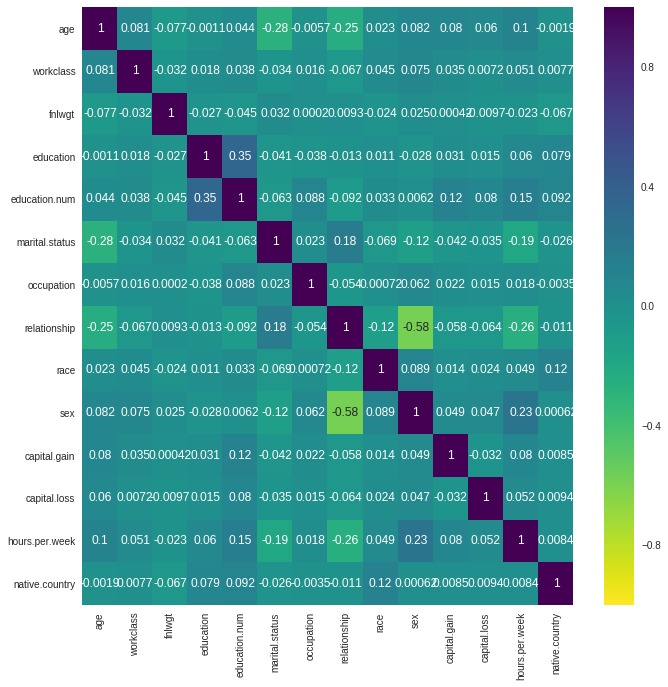

In [11]:
plt.figure(figsize=(11,11))
colormap = plt.cm.viridis_r
sns.heatmap(data.corr(), vmax=1.0, cmap=colormap, annot=True)
plt.show()

If values on this map are close to |1|, there is a correlation between features. And if the values are close to 0, there is no correlation. Good for us, we don't have this kind of situation. 

For curious people, we can create another matrix called 'scatterplot matrix'. Usually we don't know from correlation matrix how features behave between themselves. Scatterplot is useful. BUT don't use it on dataset with  many features. You won't see any scatter plot!

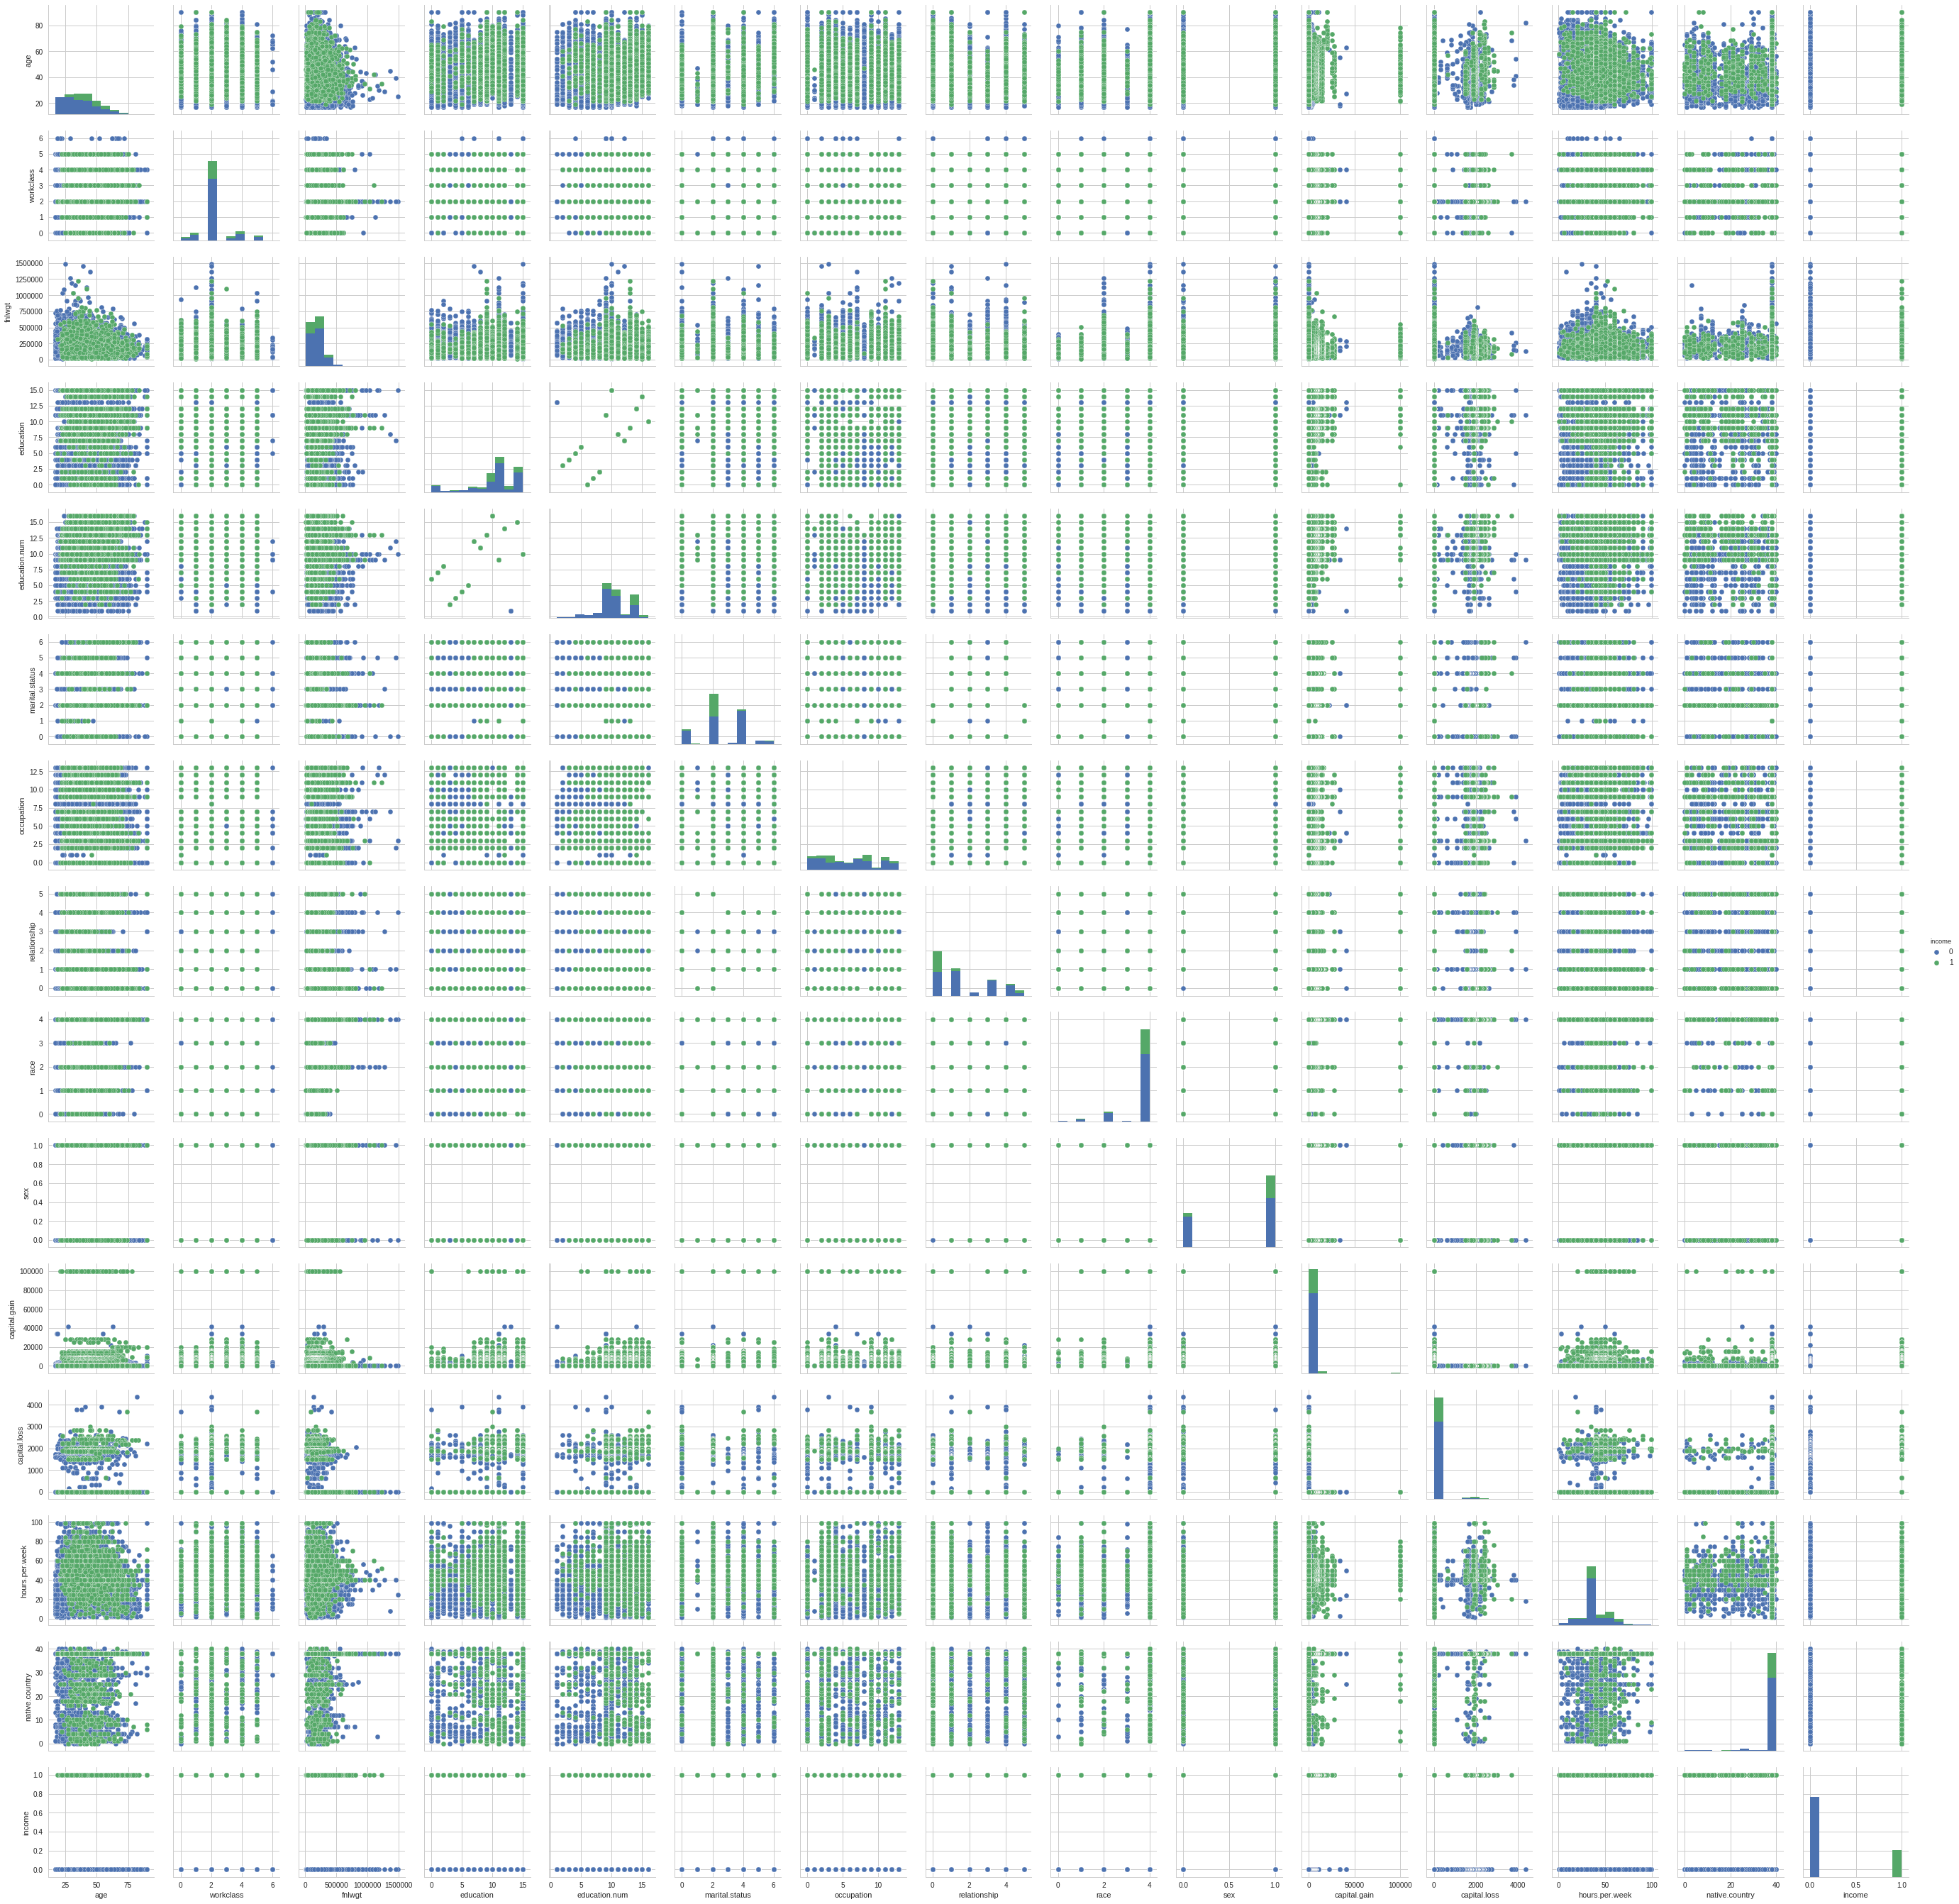

In [12]:
plt.figure(figsize=(10,10))
sns.pairplot(dataframe[dataframe.columns.values], hue='income',)
plt.show()

All right! Now we can do some Machine Learning stuff! From this point we switch from DataFrame into numpy's array!

In [13]:
data = data.as_matrix()
target = target.as_matrix()

In [14]:
print(data.shape)
print(target.shape)

(30162, 14)
(30162,)


WE will try to look for the best classifier to predict values of income.

In most of ML problems we don't know what parameters are the best for classifier. We can use two algorithms to look for solution - RandomizedSearch and GridSearch. 

To use this we need to have the 'space' of parameters to look through.

In [18]:
rand_state=42
C_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

svc_params = {
    "C":C_range,
    "kernel":['poly', 'rbf', 'sigmoid'],
    "degree":[2,3,4,5,6],
    "gamma":['auto',0.001, 0.02, 0.4, 0.8, 1.2],
    "coef0":[-2.,0.,0.001,0.2,1,2],
    "shrinking":[False,True],
    "tol":[1e-3, 1e-6,1e-4,0.1, 10],
    "cache_size":[500],
    "max_iter":[-1],
    "random_state":[rand_state]
}

log_params = [{
    "C":C_range,
    "penalty":['l1'],
    "dual":[False],
    "fit_intercept":[False, True],
    "solver":['liblinear'],
    "intercept_scaling":[0.01, 0.1, 1., 10., 100.],
    "tol":[1e-4, 1e-6, 1e-3, 0.01, 0.1],
    "warm_start":[False, True],
    "random_state":[rand_state]
},            {
    "C":C_range,
    "penalty":["l2"],
    "dual":[False, True],
    "fit_intercept":[False, True],
    "intercept_scaling":[0.01, 0.1, 1., 10., 100.],
    "solver": ["newton-cg", "lbfgs", "sag"],
    "max_iter":[100, 200, 500, 1000],
    "tol":[1e-4, 1e-6, 1e-5, 1e-3, 0.1],
    "warm_start":[False, True],
    "random_state":[rand_state]
}]

ridge_params = {
    "alpha":[0.01, 0.1, 1.0, 10., 100.],
    "copy_X":[False, True],
    "fit_intercept":[False, True],
    "max_iter":[1000, 2000, 5000, 10000, 15000],
    "normalize":[False, True],
    "solver":['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'],
    "tol":[1e-4, 1e-6, 1e-5, 0.01, 0.1],
    "random_state":[rand_state]
}

sgd_params = {
    'loss':['hinge', 'log', 'modified_huber', 'squared_hinge'],
    "penalty":['l1', 'l2', 'elasticnet'],
    "alpha":[0.001, 0.01, 0.1, 1.0, 10.],
    "l1_ratio":[0.15, 0.30, 0.5, 0.70, 0.9],
    "fit_intercept":[False, True],
    "shuffle":[True],
    "random_state":[rand_state],
    "learning_rate":["constant", "optimal", "invscaling"],
    "eta0":[0.0, 0.1, 0.3, 0.5, 0.7, 0.9],
    "power_t":[1,2,3,4,5],
    "warm_start":[False, True],
    "average":[False, True]
}

ada_params = {
    "n_estimators":[50, 100, 200, 500, 1000],
    "learning_rate":[0.001, 0.01, 0.1, 1.0, 10.],
    "random_state":[rand_state]
}

grad_params = {
    "loss":["deviance", "exponential"],
    "learning_rate":[0.001, 0.01, 0.1, 1.0, 10.],
    "max_depth":[2, 3, 4, 6, 8, 12],
    "criterion":["friedman_mse", "mse", "mae"],
    "min_samples_split":[2, 4, 6, 8],
    "min_samples_leaf":[1, 2, 4, 6, 8],
    "max_features":["auto", "sqrt", "log2", None],
    "max_leaf_nodes":[8, 10, 12, 15, 30, 40],
    "min_impurity_split":[1e-7, 1e-8, 1e-5, 1e-3, 0.1, 1.],
    "random_state":[rand_state]
}

et_params = {
    "n_estimators":[10, 20, 50, 100, 300, 800, 1200],
    "criterion": ["gini", "entropy"],
    "max_features":["auto", "sqrt", "log2", None],
    "max_depth":[3, 5, 8, 10, 15],
    "min_samples_split":[2, 3, 4, 6, 8],
    "min_samples_leaf":[1, 2, 4, 6, 8],
    "max_leaf_nodes":[8, 10, 12, 15, 30, 40],
    "min_impurity_split":[1e-7, 1e-9, 1e-5, 1e-3, 0.1, 1.],
    "bootstrap":[False, True],
    "oob_score":[False, True],
    "random_state":[rand_state],
    "warm_start":[False, True]
}

kn_params = {
    "n_neighbors":[10, 30, 50, 100, 150],
    "weights":["uniform", "distance"],
    "algorithm":["auto", "ball_tree", "kd_tree"],
    "leaf_size":[30, 50, 80, 150, 200],
    "p":[2, 3, 4, 5],
}

gpc_params = {
    "kernel":[1.0*RBF(), 0.5*RBF(), 0.1*RBF(), 1.5*RBF()],
    "n_restarts_optimizer":[0, 1, 5, 10],
    "max_iter_predict":[100, 200, 500, 1000, 1500],
    "warm_start":[False, True],
    "copy_X_train":[False, True],
    "random_state":[rand_state]
}

xgb_params = {
    "max_depth":[3,5,10,15,30],
    "learning_rate":[0.001, 0.01, 0.1, 1.0, 10],
    "n_estimators":[100, 200, 500, 1000, 1500],
    "silent":[True],
    "gamma":[0.0, 0.0001, 0.001, 0.1],
    "min_child_weight":[1,2,4,6,8],
    "max_delta_step":[0,1,2,4],
    "reg_alpha":[0.0, 0.15, 0.35, 0.65, 0.80],
    "reg_lambda":[0.0, 0.15, 0.35, 0.65, 0.80],
    "seed":[rand_state]
}

In [16]:
scaler = StandardScaler()           #  -> For me SVC need to have normalized data
data = scaler.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33)

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=rand_state)
rand_iter = 100

/home/kinshiryuu-burp/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Some algoriths can learn longer than others. So to if you want the solution but don't want to wait, use RandomizedSearch algorithm

In [ ]:
clf = SVC()
score = RandomizedSearchCV(clf, param_distributions=svc_params, n_iter=rand_iter, verbose=1, cv=cv)
score.fit(data, target)
print("Best score: %f Best parameters: %s" % (score.best_score_,score.best_params_))
means = score.cv_results_['mean_test_score']
stds = score.cv_results_['std_test_score']
params = score.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
clf = LogisticRegression()
score = RandomizedSearchCV(clf, param_distributions=log_params, n_iter=rand_iter, verbose=1, cv=cv)
score.fit(data, target)
print("Best score: %f Best parameters: %s" % (score.best_score_,score.best_params_))
means = score.cv_results_['mean_test_score']
stds = score.cv_results_['std_test_score']
params = score.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
clf = RidgeClassifier()
score = RandomizedSearchCV(clf, param_distributions=ridge_params, n_iter=rand_iter, verbose=1, cv=cv)
score.fit(data, target)
print("Best score: %f Best parameters: %s" % (score.best_score_,score.best_params_))
means = score.cv_results_['mean_test_score']
stds = score.cv_results_['std_test_score']
params = score.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
clf = AdaBoostClassifier()
score = GridSearchCV(clf, param_grid=ada_params, n_jobs=-1, verbose=1, cv=cv)
score.fit(data, target)
print("Best score: %f Best parameters: %s" % (score.best_score_,score.best_params_))
means = score.cv_results_['mean_test_score']
stds = score.cv_results_['std_test_score']
params = score.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [19]:
clf = GradientBoostingClassifier()
score = RandomizedSearchCV(clf, param_distributions=grad_params, n_iter=rand_iter, verbose=1, cv=cv)
score.fit(data, target)
print("Best score: %f Best parameters: %s" % (score.best_score_,score.best_params_))
means = score.cv_results_['mean_test_score']
stds = score.cv_results_['std_test_score']
params = score.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
clf = KNeighborsClassifier()
score = RandomizedSearchCV(clf, param_distributions=kn_params, n_iter=rand_iter, verbose=1, cv=cv)
score.fit(data, target)
print("Best score: %f Best parameters: %s" % (score.best_score_,score.best_params_))
means = score.cv_results_['mean_test_score']
stds = score.cv_results_['std_test_score']
params = score.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
clf = SGDClassifier()
score = RandomizedSearchCV(clf, param_distributions=sgd_params, n_iter=rand_iter, verbose=1, cv=cv)
score.fit(data, target)
print("Best score: %f Best parameters: %s" % (score.best_score_,score.best_params_))
means = score.cv_results_['mean_test_score']
stds = score.cv_results_['std_test_score']
params = score.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
clf = XGBClassifier()
score = RandomizedSearchCV(clf, param_distributions=xgb_params, n_iter=rand_iter, verbose=1, cv=cv)
score.fit(data, target)
print("Best score: %f Best parameters: %s" % (score.best_score_,score.best_params_))
means = score.cv_results_['mean_test_score']
stds = score.cv_results_['std_test_score']
params = score.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))